In [2]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.modeling.train import DEFAULT_PARAMS, FEATURES_FOR_MODEL

from credit_risk_xai.config import FEATURE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred_proba, n_bins=100, model_name="Model"):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.title(f"Calibration Curve - {model_name}")
    plt.show()
    
    # ECE (Expected Calibration Error)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    print(f"ECE: {ece:.4f}")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Python(70981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(70982) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [8]:
df = pd.read_parquet(FEATURE_CACHE_PATH)

In [10]:
df = df[(df["ser_aktiv"] == 1) & (df["sme_category"].isin(["Small", "Medium"])) & (df["knc_kncfall"] == 1)]
X, y = prepare_modeling_data(df)

print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Features: 73 | Samples: 316,663
Target distribution:
target_next_year
0    310079
1      6584
Name: count, dtype: Int64
Imbalance: 47.1:1


In [4]:
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import run_lightgbm_training

df = pd.read_parquet(FEATURE_CACHE_PATH)
mask = (df.ser_aktiv == 1) & (df.sme_category.isin(["Small", "Medium"]))  # add any extra filters here
X, y = prepare_modeling_data(df.loc[mask])

results = run_lightgbm_training(
    X=X,
    y=y,
    dataset_description="ser_aktiv==1 & SME∈{Small,Medium}",  # optional note for W&B
    use_wandb=False,
    wandb_project="credit-risk-xai",
    wandb_run_name="lgbm_prune_4",
)

[50]	training's binary_logloss: 0.0354142	valid_1's binary_logloss: 0.0370496
[100]	training's binary_logloss: 0.0315081	valid_1's binary_logloss: 0.0350279
[150]	training's binary_logloss: 0.0289784	valid_1's binary_logloss: 0.0345048
[200]	training's binary_logloss: 0.0270192	valid_1's binary_logloss: 0.0342745
[250]	training's binary_logloss: 0.0255407	valid_1's binary_logloss: 0.0341619
[300]	training's binary_logloss: 0.0242992	valid_1's binary_logloss: 0.0344053


In [5]:
len(FEATURES_FOR_MODEL)

73

AUC: 0.9613
PR-AUC: 0.6847

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    175077
         1.0       0.94      0.52      0.67      2901

    accuracy                           0.99    177978
   macro avg       0.97      0.76      0.83    177978
weighted avg       0.99      0.99      0.99    177978


Confusion Matrix:
[[174985     92]
 [  1398   1503]]


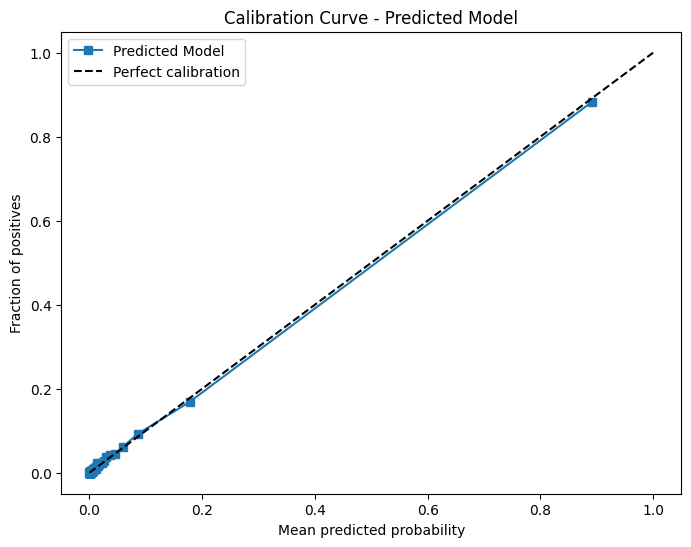

ECE: 0.0012


In [5]:
# Evaluate
model = results["model"]
X_train = results["X_train"]
X_val = results["X_val"]
y_train = results["y_train"]
y_val = results["y_val"]
y_pred_proba = results["y_val_proba"]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"AUC: {auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

plot_calibration_curve(y_val, y_pred_proba, model_name="Predicted Model")

# Feature Pruning - Phase 2 Experiments

**Immediate removals (already implemented in config):**
1. event_count_total → keep event_count_last_5y
2. rr01_ntoms_yoy_pct → r=1.0 with ny_omsf
3. ratio_ebitda_margin → r=0.998 with ny_rormarg
4. cash_conversion_cycle → r=0.971 with dso_days
5. ser_nystartat → zero variance
6. br13_ksksu, br15_lsksu → bottom 20% SHAP+tree

**Expected: 75 features (82 - 7)**

Run experiments to validate remaining decisions.

In [5]:
# Setup 5-fold CV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_feature_set(X, y, features, cv_splitter, description=""):
    aucs, pr_aucs = [], []
    for train_idx, val_idx in cv_splitter.split(X, y):
        X_tr, X_v = X.iloc[train_idx][features], X.iloc[val_idx][features]
        y_tr, y_v = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(**DEFAULT_PARAMS)
        model.fit(X_tr, y_tr, eval_set=[(X_v, y_v)], eval_metric='logloss',
                  callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)])

        y_pred = model.predict_proba(X_v)[:, 1]
        aucs.append(roc_auc_score(y_v, y_pred))
        pr_aucs.append(average_precision_score(y_v, y_pred))

    return {'description': description, 'num_features': len(features),
            'auc_mean': np.mean(aucs), 'auc_std': np.std(aucs),
            'pr_auc_mean': np.mean(pr_aucs), 'pr_auc_std': np.std(pr_aucs)}

print("✓ CV framework ready")

✓ CV framework ready


## Experiment 1: ny_rorkapo vs ratio_nwc_sales
Perfect correlation (r=1.0). Which to keep?

In [6]:
print("="*90)
print("EXPERIMENT 1: ny_rorkapo vs ratio_nwc_sales")
print("="*90)

baseline_features = X.columns.tolist()
if 'ny_rorkapo' in baseline_features and 'ratio_nwc_sales' in baseline_features:
    results_exp1 = []
    results_exp1.append(evaluate_feature_set(X, y, [f for f in baseline_features if f != 'ratio_nwc_sales'], cv, "Keep ny_rorkapo"))
    results_exp1.append(evaluate_feature_set(X, y, [f for f in baseline_features if f != 'ny_rorkapo'], cv, "Keep ratio_nwc_sales"))

    df_exp1 = pd.DataFrame(results_exp1)
    print(df_exp1.to_string(index=False))
    print(f"\nΔ AUC: {results_exp1[1]['auc_mean'] - results_exp1[0]['auc_mean']:+.6f}")
else:
    print("⚠️ Regenerate feature cache first!")

EXPERIMENT 1: ny_rorkapo vs ratio_nwc_sales
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[534]	valid_0's binary_logloss: 0.0342232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.034512
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.0338483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.0330398
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's binary_logloss: 0.0337913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.0344978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0

## Experiment 2: ny_rormarg Necessity
Test if removable given ny_nettomarg + bridge features

In [7]:
print("="*90)
print("EXPERIMENT 2: ny_rormarg Necessity")
print("="*90)

if 'ny_rormarg' in baseline_features:
    results_exp2 = []
    results_exp2.append(evaluate_feature_set(X, y, baseline_features, cv, "Both margins"))
    results_exp2.append(evaluate_feature_set(X, y, [f for f in baseline_features if f != 'ny_rormarg'], cv, "Drop ny_rormarg"))

    df_exp2 = pd.DataFrame(results_exp2)
    print(df_exp2.to_string(index=False))
    auc_loss = results_exp2[0]['auc_mean'] - results_exp2[1]['auc_mean']
    print(f"\nAUC loss: {auc_loss:+.6f}")
    print("✓ Safe" if auc_loss < 0.0003 else "⚠️ Keep")

EXPERIMENT 2: ny_rormarg Necessity
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[584]	valid_0's binary_logloss: 0.0340837
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.0344492
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	valid_0's binary_logloss: 0.0334747
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[780]	valid_0's binary_logloss: 0.0326966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[682]	valid_0's binary_logloss: 0.0334188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[591]	valid_0's binary_logloss: 0.0342371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[660]	valid_0's binary_logloss: 0.0342444

## Experiment 3: Cost Structure Ratios
Batch test for highly correlated, low-SHAP features

In [8]:
print("="*90)
print("EXPERIMENT 3: Cost Structure Ratios")
print("="*90)

cost_features = ['ratio_personnel_cost', 'ratio_other_operating_cost', 'ratio_financial_cost', 'equity_to_sales']
present = [f for f in cost_features if f in baseline_features]

if present:
    results_exp3 = []
    results_exp3.append(evaluate_feature_set(X, y, baseline_features, cv, "Baseline"))
    results_exp3.append(evaluate_feature_set(X, y, [f for f in baseline_features if f not in present], cv, "Drop all 4"))
    for feat in present:
        results_exp3.append(evaluate_feature_set(X, y, [f for f in baseline_features if f != feat], cv, f"Drop {feat}"))

    df_exp3 = pd.DataFrame(results_exp3)
    df_exp3['auc_delta'] = df_exp3['auc_mean'] - results_exp3[0]['auc_mean']
    print(df_exp3.to_string(index=False))
    print(f"\nTotal loss: {results_exp3[0]['auc_mean'] - results_exp3[1]['auc_mean']:+.6f}")

EXPERIMENT 3: Cost Structure Ratios
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[584]	valid_0's binary_logloss: 0.0340837
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.0344492
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	valid_0's binary_logloss: 0.0334747
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[780]	valid_0's binary_logloss: 0.0326966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[682]	valid_0's binary_logloss: 0.0334188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.0343052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[471]	valid_0's binary_logloss: 0.034496

In [11]:
mask = (X['ny_rorkapo'].notna()) & (X['ratio_nwc_sales'].notna())
np.linalg.norm(X['ny_rorkapo'][mask] - X['ratio_nwc_sales'][mask])

np.float32(9.138999)

In [10]:
# Is ny_rorkapo or ratio_nwc_sales more present in the data?
X['ny_rorkapo'].isna().sum(), X['ratio_nwc_sales'].isna().sum()

(np.int64(3665), np.int64(3525))

In [12]:
X['ny_rorkapo'].describe()

count    8.862240e+05
mean    -5.151728e-01
std      1.544879e+03
min     -1.409403e+06
25%      9.509695e-03
50%      8.711936e-02
75%      2.012088e-01
max      1.463400e+05
Name: ny_rorkapo, dtype: float64

In [13]:
X['ratio_nwc_sales'].describe()

count    8.863640e+05
mean    -5.151420e-01
std      1.544757e+03
min     -1.409403e+06
25%      9.500593e-03
50%      8.711666e-02
75%      2.012136e-01
max      1.463400e+05
Name: ratio_nwc_sales, dtype: float64